# Sliding time window laminar model comparison using free energy

This tutorial demonstrates how to perform laminar inference of event-related responses in a sliding time window using model comparison based on free energy as a metric of model fit, described in [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479). A temporal Gaussian function is simulated at a particular cortical location in various layers. Source reconstruction is performed on the whole time window using the Empirical Bayesian Beamformer on the simulated sensor data using a forward model based on the multilayer mesh as a localizer. This is used to select priors on each layer mesh for a sliding time window model comparison using free energy.

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import coregister, invert_ebb, load_source_time_series
from lameg.laminar import sliding_window_model_comparison
from lameg.simulate import run_dipole_simulation
from lameg.surf import interpolate_data
from lameg.util import get_surface_names
from lameg.viz import show_surface, color_map
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
nas = [0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa = [-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa = [76.02110531729883, 18.9467849625573, -25.779407159603114]

# Data file to base simulations on
data_file = os.path.join(
    '../test_data/processed', 
    subj_id, 
    ses_id, 
    'spm/pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

For source reconstructions, we need an MRI and a surface mesh. The simulations will be based on a forward model using the multilayer mesh, and the model comparison will use each layer mesh

In [2]:
# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data/spm', subj_id, 's2023-02-28_13-33-133958-00001-00224-1.nii' )

# Mesh to use for forward model in the simulations
multilayer_mesh_fname = os.path.join('../test_output', subj_id, 'multilayer.11.ds.link_vector.fixed.gii')

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Get name of each mesh that makes up the layers of the multilayer mesh - these will be used for the source 
# reconstruction
layer_fnames = get_surface_names(
    n_layers, 
    os.path.join('../test_output', subj_id), 
    'link_vector.fixed'
)

# Inflated meshes for plotting
ds_inflated = nib.load(os.path.join('../test_output', subj_id, 'inflated.ds.gii'))
orig_inflated = nib.load(os.path.join('../test_output', subj_id, 'inflated.gii'))

We're going to copy the data file to a temporary directory and direct all output there.

In [3]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/sliding_window'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [4]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


## Simulating a signal on the pial surface
We're going to simulate 200ms of a Gaussian with a dipole moment of 5nAm and a width of 25ms

Text(0, 0.5, 'Amplitude (nAm)')

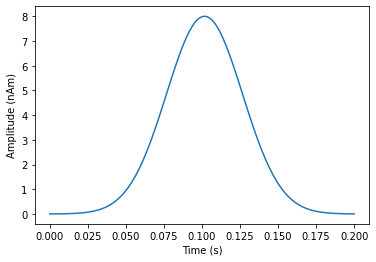

In [5]:
# Strength of simulated activity (nAm)
dipole_moment = 8
# Temporal width of the simulated Gaussian
signal_width=.025 # 25ms
# Sampling rate (must match the data file)
s_rate = 600

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time=np.linspace(0,.2,121)
zero_time=time[int((len(time)-1)/2+1)]
sim_signal=np.exp(-((time-zero_time)**2)/(2*signal_width**2)).reshape(1,-1)
plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at

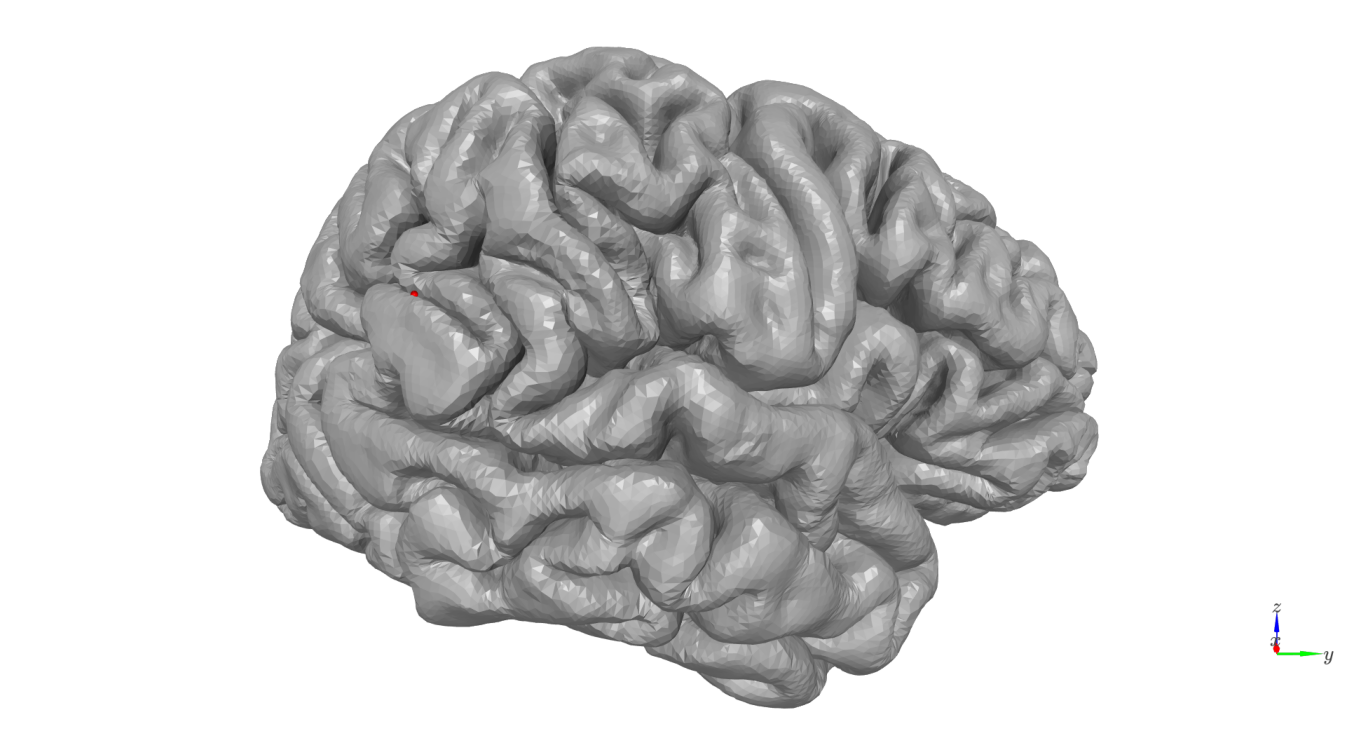

In [21]:
# Vertex to simulate activity at
sim_vertex=24588

pial_ds_mesh_fname = os.path.join('../test_output', subj_id, 'pial.ds.link_vector.fixed.gii')
pial_ds_mesh = nib.load(pial_ds_mesh_fname)
pial_coord = pial_ds_mesh.darrays[0].data[sim_vertex,:]
pial_mesh_fname = os.path.join('../test_output', subj_id, 'pial.gii')
pial_mesh = nib.load(pial_mesh_fname)
cam_view = [152, 28, 15,
            3.5, 26, 38.5,
            0, 0, 1]
plot = show_surface(
    pial_mesh, 
    opacity=1, 
    coords=pial_coord,
    coord_size=2,
    camera_view=cam_view
)

We'll simulate a 5mm patch of activity with -5 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [7]:
# Simulate at a vertex on the pial surface
pial_vertex = sim_vertex
# Orientation of the simulated dipole
pial_unit_norm = mesh.darrays[2].data[pial_vertex,:]
prefix = f'sim_{sim_vertex}_pial_'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -10

# Generate simulated data
pial_sim_fname = run_dipole_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    pial_unit_norm, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 

## Localizer inversion
Now we'll run a source reconstruction using the multilayer mesh, extract the signal in the pial layer, and select a prior based on the peak.

In [8]:
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    pial_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

layer_vertices = np.arange(verts_per_surf)
layer_ts, time, ch_names = load_source_time_series(
    pial_sim_fname, 
    mu_matrix=MU, 
    vertices=layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
prior = np.argmax(m_layer_max)

sim_coord = ds_inflated.darrays[0].data[sim_vertex,:]
prior_coord = ds_inflated.darrays[0].data[prior,:]

print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')
print('Simulated coordinate')
print(sim_coord)
print('Prior coordinate')
print(prior_coord)

Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulated vertex=24588, Prior vertex=24588
Simulated coordinate
[167.26544   -24.875505    6.3826694]
Prior coordinate
[167.26544   -24.875505    6.3826694]


We can see that the prior is the same as the location we simulated at

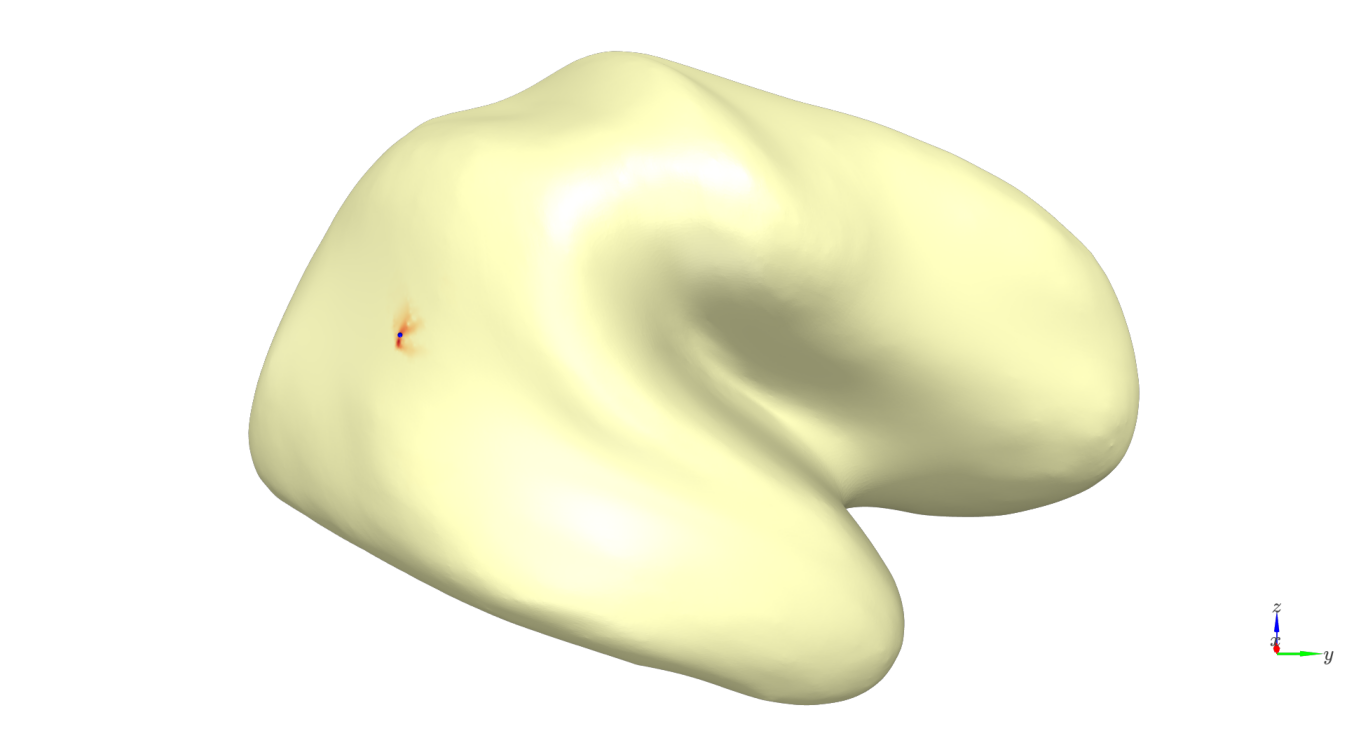

In [18]:
# Interpolate for display on the original inflated surface
interpolated_data = interpolate_data(orig_inflated, ds_inflated, m_layer_max)
          
# Plot colors and camera view
max_abs = np.max(np.abs(m_layer_max))
c_range = [-max_abs, max_abs]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot peak
colors,_ = color_map(
    interpolated_data, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]    
)

plot = show_surface(
    orig_inflated, 
    colors=colors, 
    info=True, 
    camera_view=cam_view, 
    coords=prior_coord, 
    coord_size=2, 
    coord_color=[0,0,255]
)

## Sliding time window model comparison (pial - white matter)
Now we can run sliding time window model comparison between source models based on the pial and white matter surfaces using free energy. Specifically, we'll look at the difference in free energy between the two models (pial - white matter), in sliding and overlapping windows of 16ms. The free energy difference (pial - white matter) should be positive (more model evidence for the pial surface model) because we simulated activity on the pial surface.

Smoothing ../test_output/sub-104/pial.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ../test_output/sub-104/white.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


Text(0, 0.5, '$\\Delta$F')

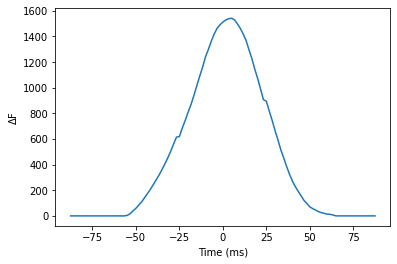

In [10]:
# Number of temporal models for sliding time window inversion
sliding_n_temp_modes = 4
# Size of sliding window (in ms)
win_size = 50
# Whether or not windows overlap
win_overlap = True

# Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    pial_sim_fname, 
    patch_size=patch_size, 
    n_temp_modes=sliding_n_temp_modes,
    win_size=win_size, 
    win_overlap=win_overlap,
    spm_instance=spm
)

# Plot difference in free energy over time (pial minus white) - this should be positive
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

## White matter surface simulation with pial - white matter sliding time window model comparison
Let's simulate the same pattern of activity, in the same location, but on the white matter surface. This time, sliding time window model comparison should yield greater model evidence for the white matter surface, and therefore the difference in free energy (pial - white matter) should be negative.

Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulated vertex=24588, Prior vertex=24588
Simulated coordinate
[167.26544   -24.875505    6.3826694]
Prior coordinate
[167.26544   -24.875505    6.3826694]
Smoothing ../test_output/sub-104/pial.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ../test_output/sub-104/white.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


Text(0, 0.5, '$\\Delta$F')

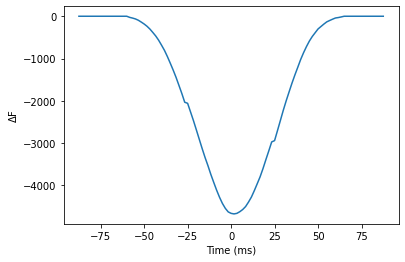

In [11]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = (n_layers-1)*verts_per_surf+sim_vertex
prefix = f'sim_{sim_vertex}_white_'

# Generate simulated data
white_sim_fname = run_dipole_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    pial_unit_norm, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 

# Localizer
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    white_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

layer_vertices = np.arange(verts_per_surf)
layer_ts, time, _ = load_source_time_series(
    white_sim_fname, 
    mu_matrix=MU, 
    vertices=layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
prior = np.argmax(m_layer_max)
prior_coord = ds_inflated.darrays[0].data[prior,:]

print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')
print('Simulated coordinate')
print(sim_coord)
print('Prior coordinate')
print(prior_coord)

# Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    white_sim_fname, 
    patch_size=patch_size, 
    n_temp_modes=sliding_n_temp_modes,
    win_size=win_size, 
    win_overlap=win_overlap,
    spm_instance=spm
)

# Plot difference in free energy over time (pial minus white) - this should be negative
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

## Simulation in each layer with sliding time window model comparison across layers
That was sliding time window model comparison with two candidate models: one based on the white matter surface, and one on the pial. Let's now simulate on each layer, and for each simulation, run sliding time window model comparison across all layers. We'll turn off SPM visualization here.

In [13]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run sliding window model 
# comparison across all layers
all_layerF = []
for l in range(n_layers):
    print(f'Simulating in layer {l}')
    l_vertex = l*verts_per_surf+sim_vertex
    prefix = f'sim_{sim_vertex}{l}_'
    
    l_sim_fname = run_dipole_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        pial_unit_norm, 
        dipole_moment, 
        sim_patch_size, 
        SNR, 
        spm_instance=spm
    ) 
    
    # Localizer
    [_,_,MU] = invert_ebb(
        multilayer_mesh_fname, 
        l_sim_fname, 
        n_layers, 
        patch_size=patch_size, 
        n_temp_modes=n_temp_modes,
        return_mu_matrix=True,
        spm_instance=spm
    )

    layer_vertices = np.arange(verts_per_surf)
    layer_ts, time, _ = load_source_time_series(
        l_sim_fname, 
        mu_matrix=MU, 
        vertices=layer_vertices
    )

    # Layer peak
    m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
    prior = np.argmax(m_layer_max)    
    prior_coord = ds_inflated.darrays[0].data[prior,:]

    print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')
    print('Simulated coordinate')
    print(sim_coord)
    print('Prior coordinate')
    print(prior_coord)

    [Fs,wois] = sliding_window_model_comparison(
        prior, 
        nas, 
        lpa, 
        rpa, 
        mri_fname, 
        layer_fnames, 
        l_sim_fname, 
        patch_size=patch_size, 
        n_temp_modes=sliding_n_temp_modes,
        win_size=win_size, 
        win_overlap=win_overlap,
        viz=False,
        spm_instance=spm
    )
    
    all_layerF.append(Fs)
all_layerF = np.squeeze(np.array(all_layerF))

Simulating in layer 0
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulated vertex=24588, Prior vertex=24588
Simulated coordinate
[167.26544   -24.875505    6.3826694]
Prior coordinate
[167.26544   -24.875505    6.3826694]
Smoothing ../test_output/sub-104/pial.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.11 times vertex spacing
Smoothing ../test_output/sub-104/0.900.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.15 times vertex spacing
Smoothing ../test_output/sub-104/0.800.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.20 times vertex spacing
Smoothing ../test_output/sub-104/0.700.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.24 times vertex spacing
Smoothing ../test_output/sub-104/0.600.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.29 times vertex spacing
Smoothing ../test_output/sub-104/0.500.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Smoothing ../test_outpu

Smoothing ../test_output/sub-104/0.800.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.20 times vertex spacing
Smoothing ../test_output/sub-104/0.700.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.24 times vertex spacing
Smoothing ../test_output/sub-104/0.600.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.29 times vertex spacing
Smoothing ../test_output/sub-104/0.500.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Smoothing ../test_output/sub-104/0.400.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.38 times vertex spacing
Smoothing ../test_output/sub-104/0.300.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.43 times vertex spacing
Smoothing ../test_output/sub-104/0.200.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.48 times vertex spacing
Smoothing ../test_output/sub-104/0.100.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.53 times vertex spacing
Smoothing ../test_output/sub-104/white.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.58 time

Smoothing ../test_output/sub-104/0.300.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.43 times vertex spacing
Smoothing ../test_output/sub-104/0.200.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.48 times vertex spacing
Smoothing ../test_output/sub-104/0.100.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.53 times vertex spacing
Smoothing ../test_output/sub-104/white.ds.link_vector.fixed.gii
FWHM of 5.00 is approx 3.58 times vertex spacing


For each simulation, we can plot the free energy for all models relative to the worst model within a central time window. The layer model with the highest free energy should correspond to the layer that the activity was simulated in.

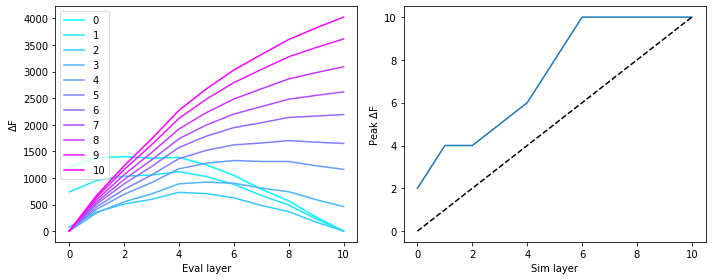

In [14]:
# Average free energy within small time window in center of the epoch
woi_t = np.mean(wois,axis=-1)
woi_idx = np.where((woi_t>=-20) & (woi_t<=20))[0]
m_all_layerF = np.mean(all_layerF[:,:,woi_idx],axis=2)

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the mean free energy of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(n_layers):
    layerF = m_all_layerF[l,:]
    plt.plot(layerF-np.min(layerF), label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel(r'$\Delta$F')

# For each simulation, find which layer model had the greatest free energy
plt.subplot(1,2,2)
peaks=[]
for l in range(n_layers):
    layerF = m_all_layerF[l,:]
    layerF = layerF-np.min(layerF)
    pk = np.argmax(layerF)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel(r'Peak $\Delta$F')
plt.tight_layout()

In [15]:
spm.terminate()

# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)